In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#import libralies

from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline

In [3]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class

In [4]:
# loading data
!unzip -qq '/content/gdrive/MyDrive/archive.zip'

In [6]:
!ls '/content/train'

daisy  dandelion  rose	sunflower  tulip


In [5]:
!ls '/content/test'

Image_100.jpg  Image_268.jpg  Image_434.jpg  Image_600.jpg  Image_768.jpg
Image_101.jpg  Image_269.jpg  Image_435.jpg  Image_601.jpg  Image_769.jpg
Image_102.jpg  Image_26.jpg   Image_436.jpg  Image_602.jpg  Image_76.jpg
Image_103.jpg  Image_270.jpg  Image_437.jpg  Image_603.jpg  Image_770.jpg
Image_104.jpg  Image_271.jpg  Image_438.jpg  Image_604.jpg  Image_771.jpg
Image_105.jpg  Image_272.jpg  Image_439.jpg  Image_605.jpg  Image_772.jpg
Image_106.jpg  Image_273.jpg  Image_43.jpg   Image_606.jpg  Image_773.jpg
Image_107.jpg  Image_274.jpg  Image_440.jpg  Image_607.jpg  Image_774.jpg
Image_108.jpg  Image_275.jpg  Image_441.jpg  Image_608.jpg  Image_775.jpg
Image_109.jpg  Image_276.jpg  Image_442.jpg  Image_609.jpg  Image_776.jpg
Image_10.jpg   Image_277.jpg  Image_443.jpg  Image_60.jpg   Image_777.jpg
Image_110.jpg  Image_278.jpg  Image_444.jpg  Image_610.jpg  Image_778.jpg
Image_111.jpg  Image_279.jpg  Image_445.jpg  Image_611.jpg  Image_779.jpg
Image_112.jpg  Image_27.jpg   Image_446

เนื่องจาก test folder ไม่มี label ดังนั้นในการเทรน NN จะใช้ train folder

In [7]:
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator, load_img

# Define Constants
img_width = 200
img_height = 200
img_channel = 3
img_size = (img_width, img_height)
img_shape = (img_width, img_height, img_channel)
batch_size= 64

# Imggen for training (and validating) data
imggen = ImageDataGenerator(rescale=1./255,
                            shear_range=.2, 
                            rotation_range=.2, 
                            width_shift_range=.1,
                            height_shift_range=.1,
                            horizontal_flip = True)

# Imggen for testing data
imggen2 = ImageDataGenerator(rescale=1./255)

In [8]:
train_set = imggen.flow_from_directory('/content/train', batch_size = 64, target_size = (200,200))

# no label in test folder
test_set = imggen.flow_from_directory('/content/test', batch_size = 64, target_size = (200,200))

Found 2746 images belonging to 5 classes.
Found 0 images belonging to 0 classes.


In [9]:
# Build a convolutional neural network
#construct custom model
CNN = models.Sequential()

# Feature extraction – the hidden layers
# convolutional layer
CNN.add(layers.Conv2D(filters= 32,
                        strides = (2, 2),
                        kernel_size=3,
                        padding='same',
                        activation = 'relu',
                        kernel_initializer='he_uniform',
                        input_shape=img_shape,
                        name = 'conv_1',
                        ))

# Batch normalization for faster NN training
CNN.add(layers.BatchNormalization())

# Maxpooling layer to reduce dimensionality of the Feature 
CNN.add(layers.MaxPooling2D(2,2))

# Dropout to prevent Overfitting
CNN.add(layers.Dropout(0.25))

# repeat the same pattern (but change the filters)
CNN.add(layers.Conv2D(filters= 64,
                        strides = (2, 2),
                        kernel_size=3,
                        padding='same',
                        activation = 'relu',
                        kernel_initializer='he_uniform',
                        input_shape=img_shape,
                        name = 'conv_2',
                        ))
CNN.add(layers.BatchNormalization())
CNN.add(layers.MaxPooling2D(2,2))
CNN.add(layers.Dropout(0.25))

CNN.add(layers.Conv2D(filters= 128,
                        strides = (2, 2),
                        kernel_size=3,
                        padding='same',
                        activation = 'relu',
                        kernel_initializer='he_uniform',
                        input_shape=img_shape,
                        name = 'conv_3',
                        ))
CNN.add(layers.BatchNormalization())
CNN.add(layers.MaxPooling2D(2,2))
CNN.add(layers.Dropout(0.25))

CNN.add(layers.Conv2D(filters= 256,
                        strides = (2, 2),
                        kernel_size=3,
                        padding='same',
                        activation = 'relu',
                        kernel_initializer='he_uniform',
                        input_shape=img_shape,
                        name = 'conv_4',
                        ))
CNN.add(layers.BatchNormalization())
CNN.add(layers.MaxPooling2D(2,2))
CNN.add(layers.Dropout(0.25))

# flatten to column vector
CNN.add(layers.Flatten())

# fully connected layer 
CNN.add(layers.Dense(256,activation='relu',
                     kernel_initializer='he_uniform',
                     name='fully_connect_1'
                     ))

CNN.add(layers.Dense(256,activation='relu',
                     kernel_initializer='he_uniform',
                     name='fully_connect_2'
                     ))
CNN.add(layers.Dropout(0.25))

# for classification task
CNN.add(layers.Dense(5,activation='softmax',
                     kernel_initializer='he_uniform',
                     name='output'
                    ))

# using adam optimizer (the smarter ball) for adjusting weights
CNN.compile(optimizer='adam',
           loss = 'categorical_crossentropy',
           metrics=['acc'])

CNN.save('cnn.h5')
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 64)       2

รูปแบบของโมเดล CNN แบ่งคร่าวๆเป็นชั้นที่ใช้ดึง feature จากรูปภาพ และ ชั้น MLP ที่ทำการเรียนรู้ ปรับ weight และแยกประเภท ชั้นที่ใช้ดึง feature จากรูปภาพ ประกอบด้วย convolution layer ที่ใช้ activation function เป็น ReLu เนื่องจากสามารถประมวลผลได้ไวกว่า activation fuction อื่น และ pooling layer แบบ Max pooling รวมถึงการทำ batch normalization เพื่อลดเวลาที่ใช้เทรนโมเดล และ dropout เพื่อหลีกเลี่ยงการเกิด overfit  ชั้น MLP ในชั้นที่ทำการแยกประเภท ใช้ activation function เป็น softmax และมีจำนวน neuron เท่ากับจำนวนคลาสของข้อมูล

In [10]:
# callback to prevent overfitting
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)
# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

ไม่ได้ใช้ callback function เนื่องจากต้อง monitor ที่ค่า validation loss ที่คำนวณจาก validation set (ซึ่งชุดข้อมูลที่มีอยู่ไม่มี label จึงนำมาใช้ไม่ได้)

In [11]:
history = CNN.fit(train_set, batch_size=64, epochs=10)
CNN.save('cnn.h5')

Epoch 1/10
43/43 [==============================] - 65s 1s/step - loss: 1.7930 - acc: 0.3795
Epoch 2/10
43/43 [==============================] - 62s 1s/step - loss: 1.2885 - acc: 0.4905
Epoch 3/10
43/43 [==============================] - 62s 1s/step - loss: 1.1986 - acc: 0.5124
Epoch 4/10
43/43 [==============================] - 61s 1s/step - loss: 1.1084 - acc: 0.5503
Epoch 5/10
43/43 [==============================] - 62s 1s/step - loss: 1.0462 - acc: 0.5863
Epoch 6/10
43/43 [==============================] - 61s 1s/step - loss: 1.0120 - acc: 0.5961
Epoch 7/10
43/43 [==============================] - 61s 1s/step - loss: 0.9499 - acc: 0.6205
Epoch 8/10
43/43 [==============================] - 64s 1s/step - loss: 0.9405 - acc: 0.6238
Epoch 9/10
43/43 [==============================] - 62s 1s/step - loss: 0.9191 - acc: 0.6351
Epoch 10/10
43/43 [==============================] - 62s 1s/step - loss: 0.8775 - acc: 0.6449


จากการเทรนโมเดล ได้ค่า accuracy = 0.6449 เนื่องจากเป็น multi class classification task ทำให้การแยกประเภทรูปภาพทำได้ยากกว่า binary class classification 
อีกเหตุผลหนึ่งที่อาจทำให้ accuracy ต่ำ อาจเป็นเพราะข้อมูลที่ใช้เทรนมีจำนวนไม่มากพอ หรือจำนวน epoch ในการเทรนน้อย (หรืออาจเป็นที่โครงสร้างโมเดล หรือ hyperparameter หากมีเวลาเพิ่มในการทดสอบกับโมเดลหลายๆรูปแบบ อาจจะสามารถสรุปได้ชัดเจนขึ้น) 
นอกจากนี้การเทรนโมเดลยังไม่มีชุดข้อมูล validation สำหรับการทดสอบว่าโมเดล overfit หรือไม่ (เนื่องจากมีเวลาจำกัดในการศึกษาหาวิธีการเพิ่มเติม + ตัว test data ไม่มี label จึงไม่สามารถนำมาใช้ในการทดสอบโมเดลได้ + ไม่สามารถนำข้อมูล train มาใช้ test ได้)

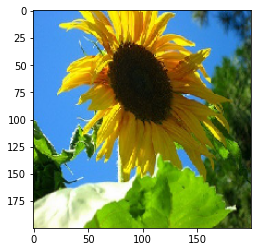

In [12]:
    from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
    img = image.load_img('/content/test/Image_1.jpg', target_size=(200, 200))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    pred_class = CNN.predict(img_preprocessed).argmax(axis =1)

In [13]:
pred_class

array([0])